<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Symmetric Noise 20%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.2
loss_function = 'DampedCELoss' 
dataset = 'aircrafts'
noise_type = 'sym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedCELoss_aircrafts_sym_0.2_0.25_baseline
Model Features: DampedCELoss_aircrafts_sym_0.2_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedCELoss_aircrafts_sym_0.2_0.25
Csv save: DampedCELoss_aircrafts_sym_0.2_0.25
Saving features from Scheme delta = 0.25: DampedCELoss_aircrafts_sym_0.2_0.5
Saving csv for damp_2: DampedCELoss_aircrafts_sym_0.2_0.5


# Declaration of models Net family with Resolution, Epochs, and Batch size

In [4]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [7]:
import pandas as pd
train_df = pd.read_csv('aircrafts_sym_0.2.csv')
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,5,0,0
2,aircrafts_original/0/1427680.jpg,62,0,0
3,aircrafts_original/0/1017179.jpg,31,0,0
4,aircrafts_original/0/0536721.jpg,61,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [10]:
print(train_df.Noisy_labels.tolist())

[1, 5, 62, 31, 61, 72, 24, 99, 74, 1, 37, 50, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 74, 25, 37, 41, 94, 96, 99, 62, 76, 42, 77, 90, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 96, 50, 73, 18, 79, 72, 40, 97, 71, 42, 37, 65, 30, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 19, 6, 75, 86, 61, 52, 27, 7, 82, 19, 30, 35, 40, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 29, 16, 79, 20, 80, 5, 81, 18, 79, 35, 86, 57, 71, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

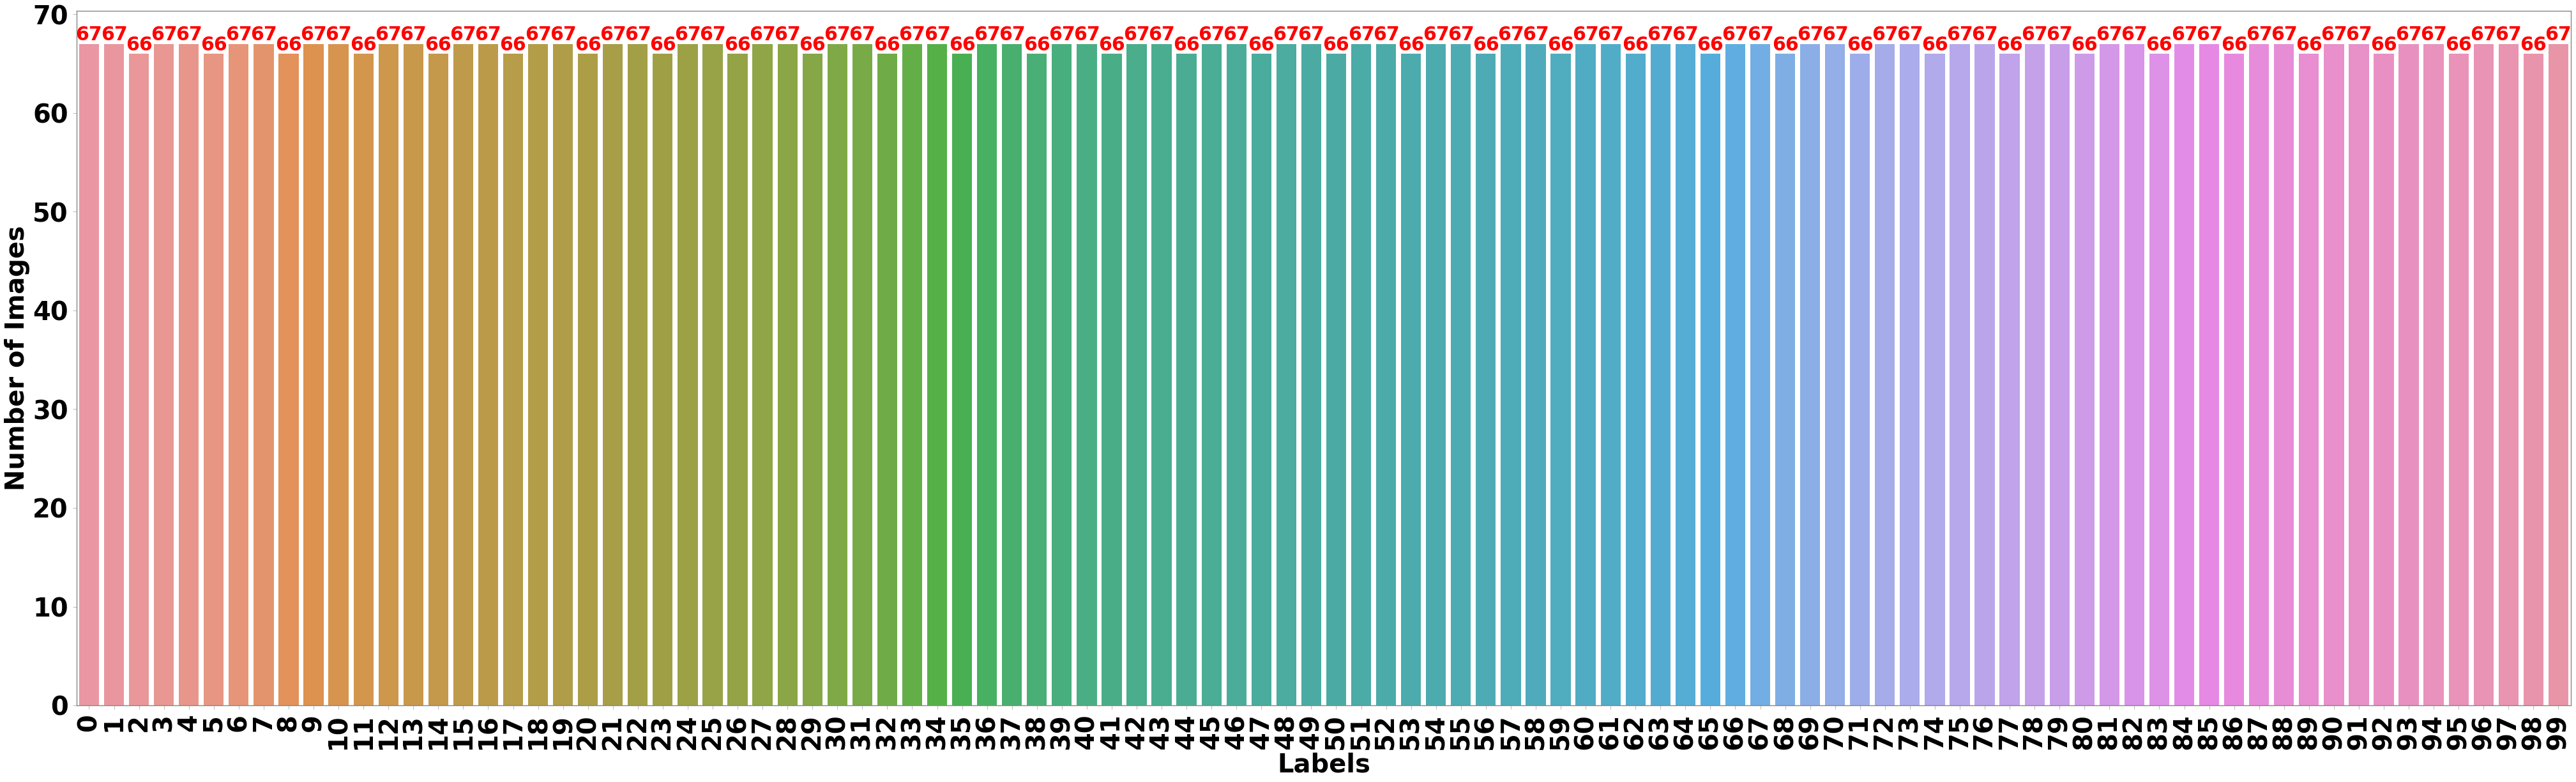

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [12]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [15]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


Text(0, 0.5, 'Number of Images')

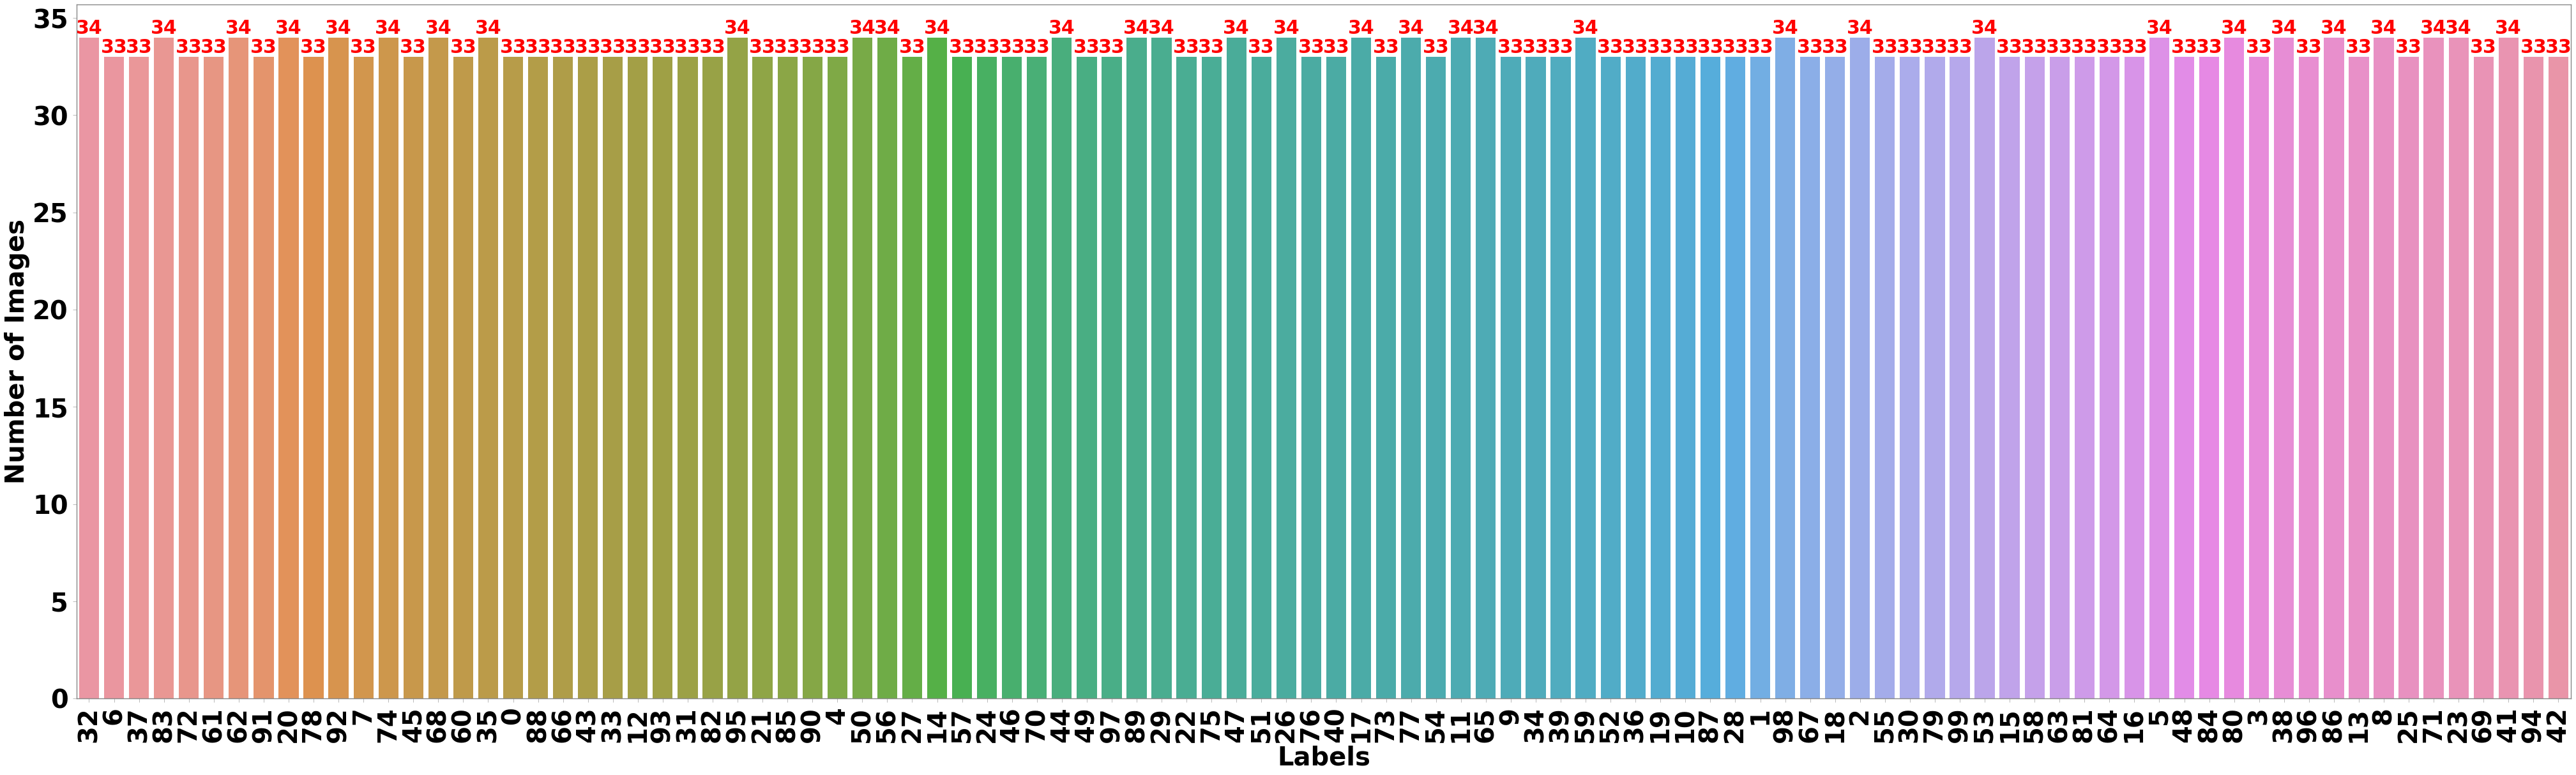

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [20]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [21]:

# default augmentation
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


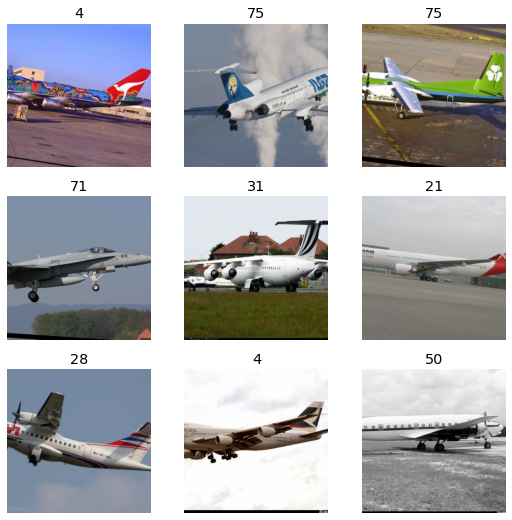

In [22]:
data0.show_batch()

In [23]:
import damped_losses as losses
loss_func = losses.DampedCELossFlat(num_classes=196,delta=0.0,reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=196)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [4]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,cbs=[ShowGraphCallback(),checkpoints]).to_fp16())

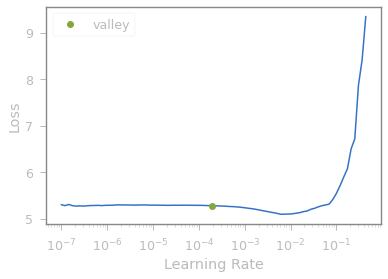

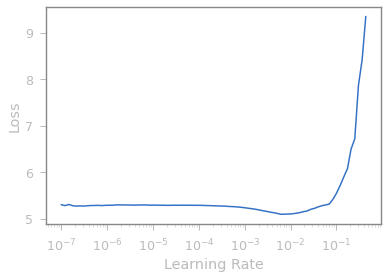

In [25]:
learn.lr_find()
learn.recorder.plot_lr_find()

Parameters used in SECLoss functions are;
epochs: 120  train_batch_size: 128  lr: 0.01  alpha: 0.1 beta: 1.0


epoch,train_loss,valid_loss,accuracy,time
0,3.878996,3.499857,0.183046,01:49
1,3.052171,3.396399,0.269317,01:49
2,2.674592,3.252835,0.317329,01:49
3,2.283543,2.803872,0.488372,01:49
4,2.044004,2.769949,0.504876,01:49
5,1.589153,2.731591,0.579145,01:49
6,1.110355,2.702421,0.598650,01:49
7,0.685880,2.778401,0.612903,01:49
8,0.340276,2.872178,0.619655,01:49
9,0.271033,2.840032,0.621155,01:49


Better model found at epoch 0 with accuracy value: 0.18304575979709625.


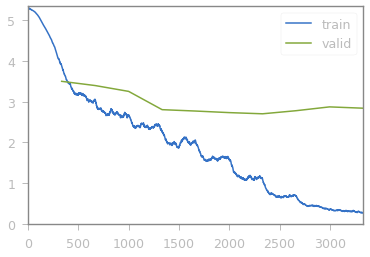

Better model found at epoch 1 with accuracy value: 0.2693173289299011.
Better model found at epoch 2 with accuracy value: 0.3173293471336365.
Better model found at epoch 3 with accuracy value: 0.4883720874786377.
Better model found at epoch 4 with accuracy value: 0.5048761963844299.
Better model found at epoch 5 with accuracy value: 0.5791447758674622.
Better model found at epoch 6 with accuracy value: 0.5986496806144714.
Better model found at epoch 7 with accuracy value: 0.6129032373428345.
Better model found at epoch 8 with accuracy value: 0.6196548938751221.
Better model found at epoch 9 with accuracy value: 0.6211552619934082.


In [26]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [27]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.308384,2.846428,0.619655,01:49
1,0.272821,2.946348,0.621155,01:49
2,0.227124,3.090754,0.603151,01:49
3,0.256779,3.265371,0.584396,01:49
4,0.285096,3.302220,0.563391,01:49
5,0.413546,3.601150,0.543886,01:49
6,0.530259,3.610120,0.511628,01:49
7,0.560885,4.013797,0.499625,01:49
8,0.721131,3.877474,0.470368,01:49
9,0.827128,3.999467,0.452363,01:49


Better model found at epoch 0 with accuracy value: 0.6196548938751221.


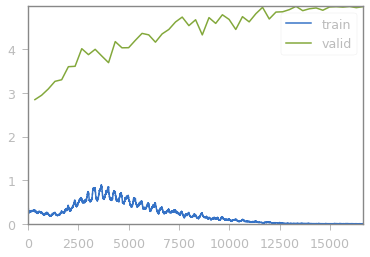

Better model found at epoch 1 with accuracy value: 0.6211552619934082.


In [28]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [29]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.7696)


In [30]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.7819)


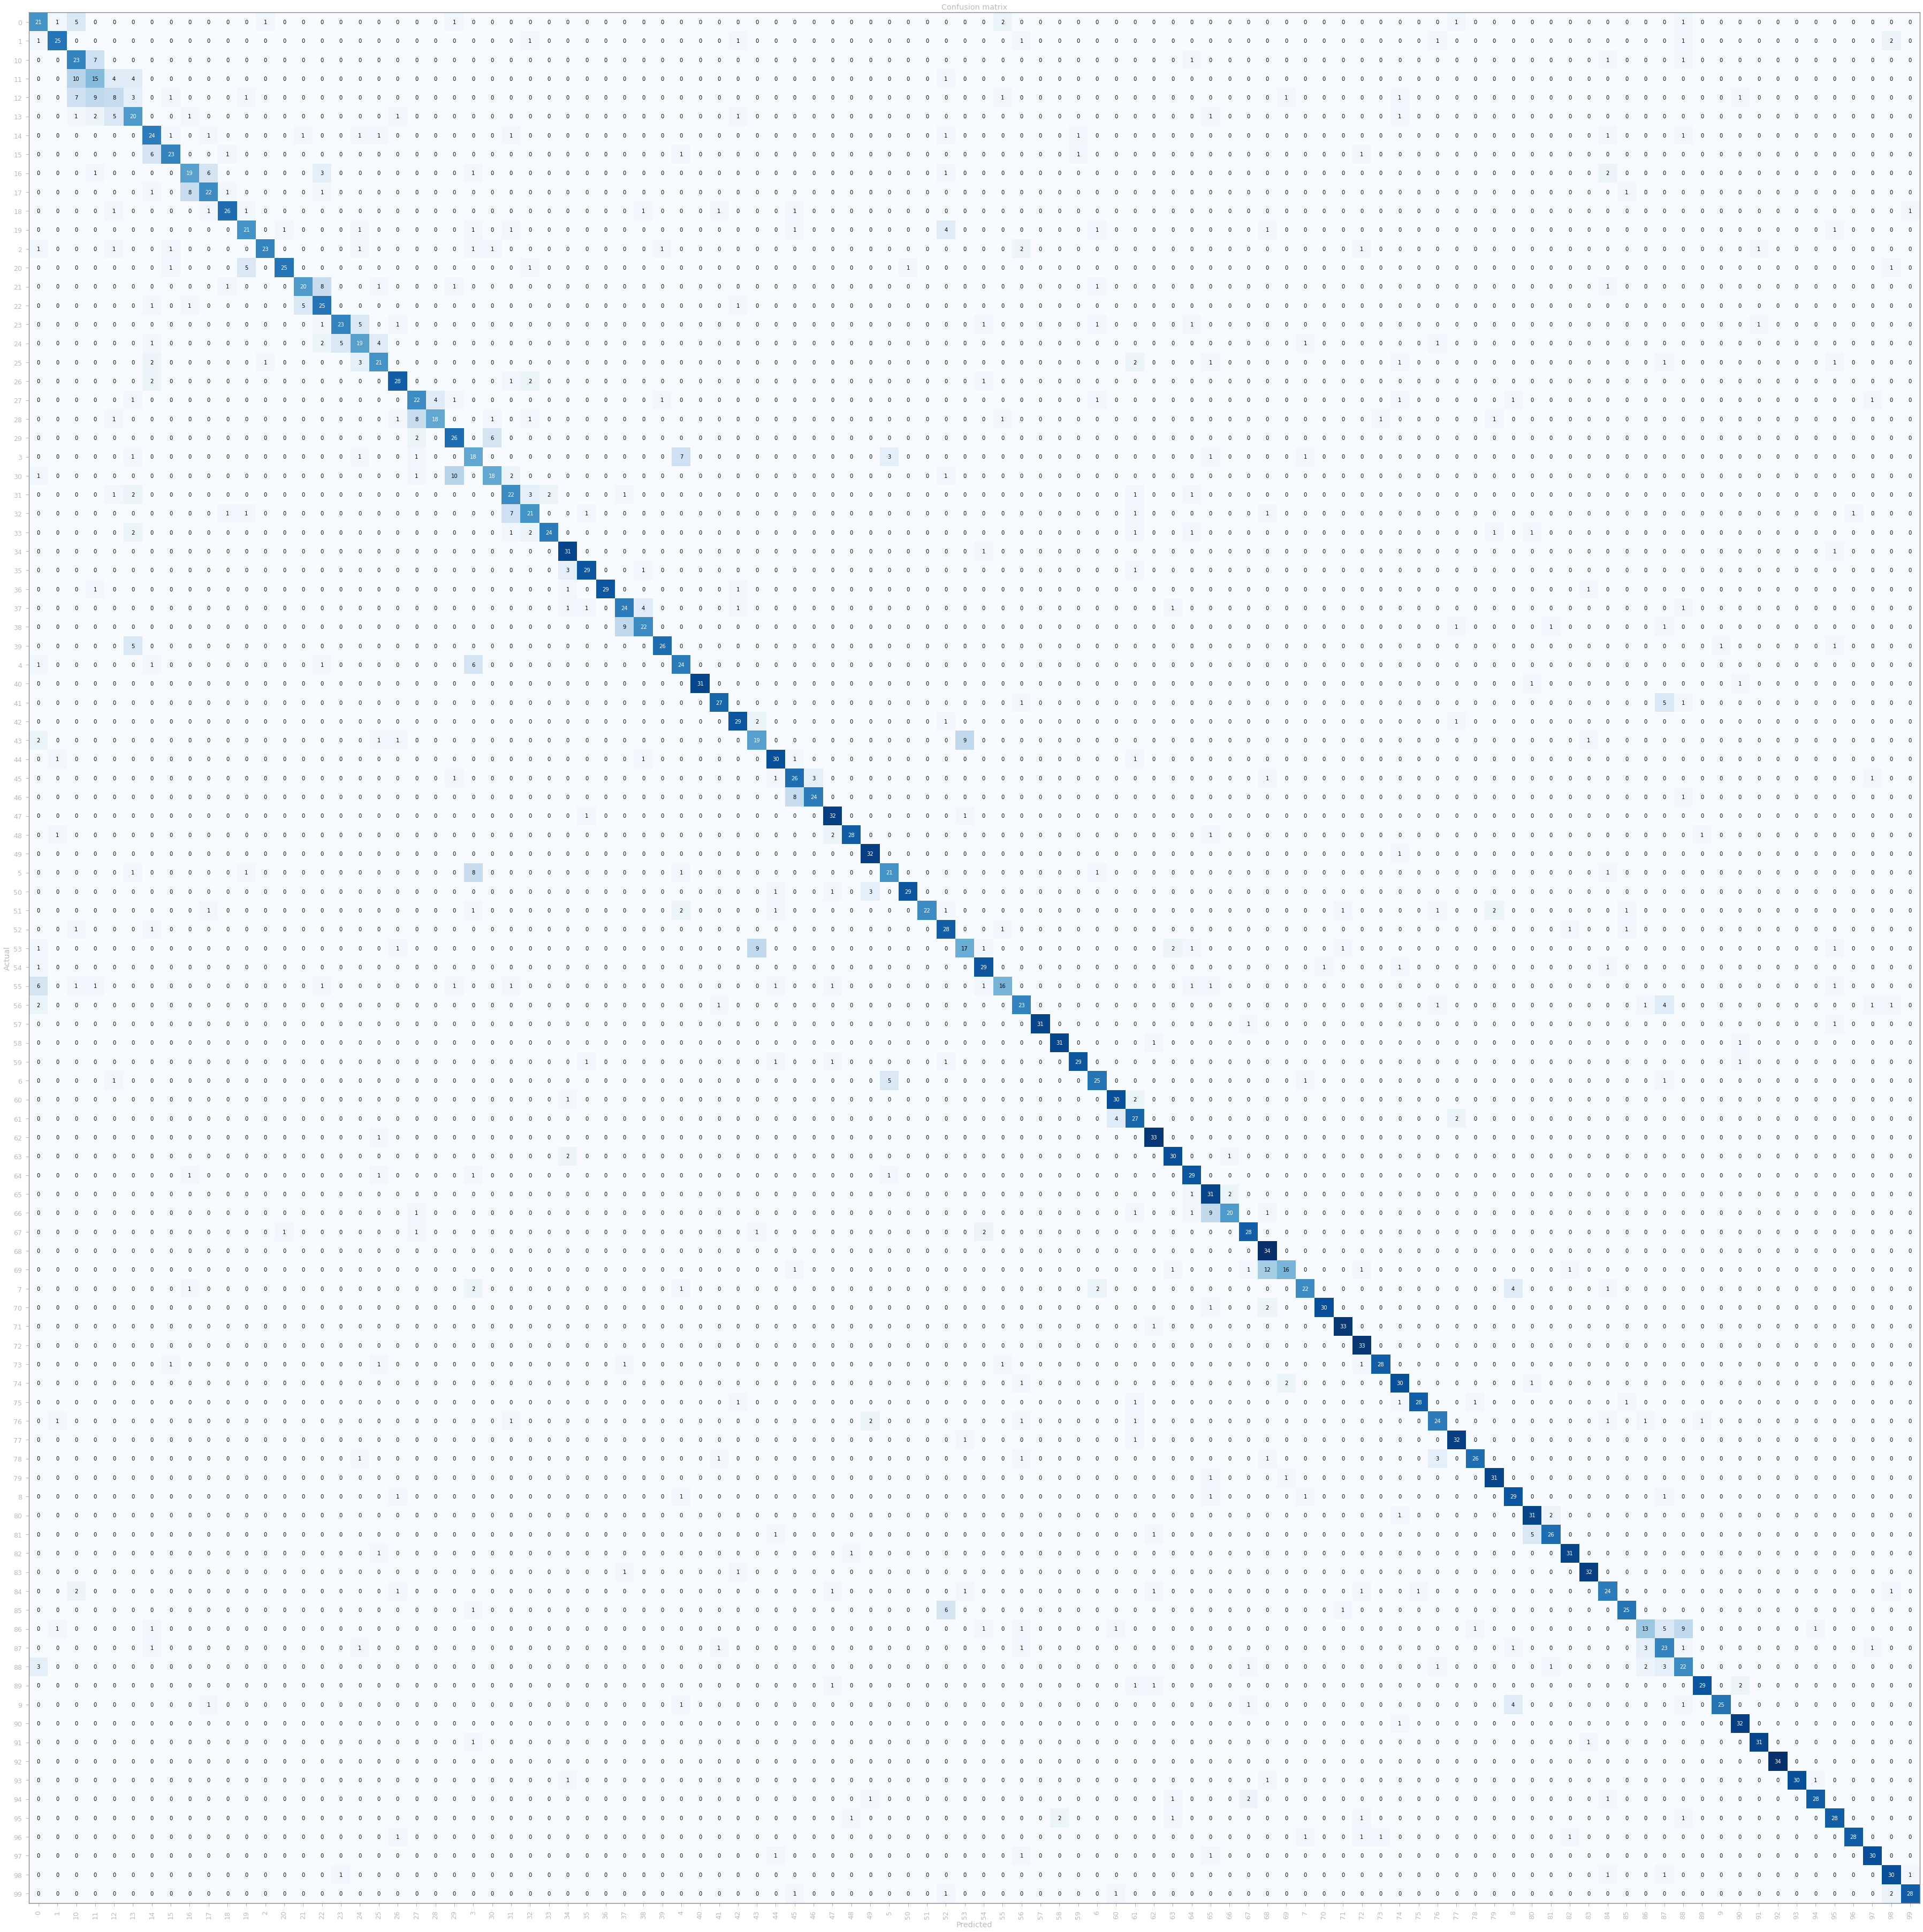

In [31]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [32]:
PATH="models/ce_aircrafts_dumpsCls_sym20_baseline_b4.p"
torch.save(model.state_dict(), PATH)

In [33]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/ce_aircrafts_dumpsCls_sym20_b4.pth'

In [34]:
drop_idxx = []
los = []
top_losses = []
k_samples=100

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)    
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,img_size,tfms,model,best_pth,k_samples= k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    interp.plot_top_losses(100, figsize = (11,15))
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered


delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 91 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6576


epoch,train_loss,valid_loss,accuracy,time
0,0.232598,0.117871,0.925475,01:48


Better model found at epoch 0 with accuracy value: 0.9254752993583679.


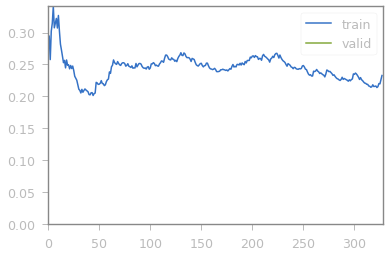

************Round:  0
TTA Accuracy:0.7989798784255981
cycle 0 Error Rate is [{0: (1.364931753412324, 20.102012157440186)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 83 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6493


epoch,train_loss,valid_loss,accuracy,time
0,0.204488,0.082350,0.916795,01:47


Better model found at epoch 0 with accuracy value: 0.9167950749397278.


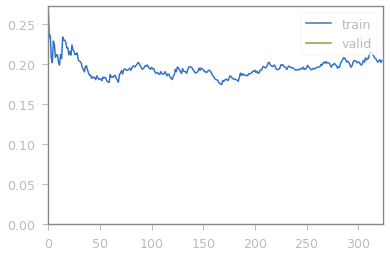

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 78 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6415


epoch,train_loss,valid_loss,accuracy,time
0,0.178731,0.065856,0.908807,01:45


Better model found at epoch 0 with accuracy value: 0.9088074564933777.


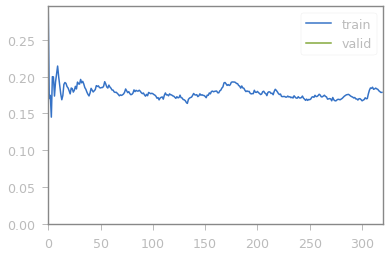

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 79 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6336


epoch,train_loss,valid_loss,accuracy,time
0,0.143097,0.059483,0.921863,01:44


Better model found at epoch 0 with accuracy value: 0.9218626618385315.


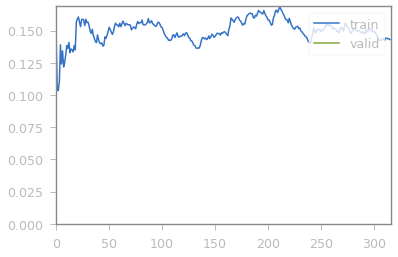

************Round:  3
TTA Accuracy:0.8022802472114563
cycle 0 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 83 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6253


epoch,train_loss,valid_loss,accuracy,time
0,0.141210,0.056565,0.905600,01:43


Better model found at epoch 0 with accuracy value: 0.9056000113487244.


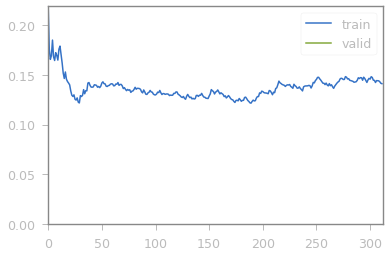

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 71 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6182


epoch,train_loss,valid_loss,accuracy,time
0,0.131895,0.052961,0.911003,01:43


Better model found at epoch 0 with accuracy value: 0.9110032320022583.


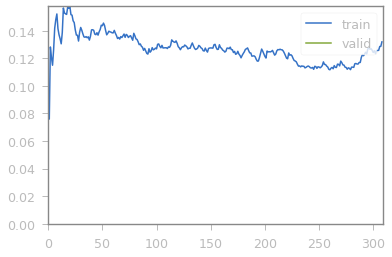

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 72 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6110


epoch,train_loss,valid_loss,accuracy,time
0,0.125831,0.042006,0.913257,01:42


Better model found at epoch 0 with accuracy value: 0.9132569432258606.


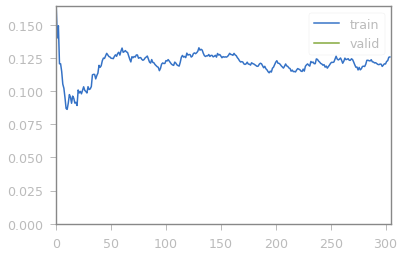

************Round:  6
TTA Accuracy:0.8115811347961426
cycle 0 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 70 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6040


epoch,train_loss,valid_loss,accuracy,time
0,0.115167,0.046797,0.905629,01:41


Better model found at epoch 0 with accuracy value: 0.9056291580200195.


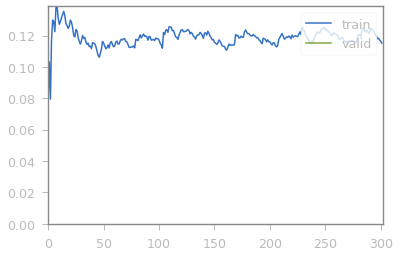

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 71 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5969


epoch,train_loss,valid_loss,accuracy,time
0,0.111219,0.041051,0.915339,01:40


Better model found at epoch 0 with accuracy value: 0.915339469909668.


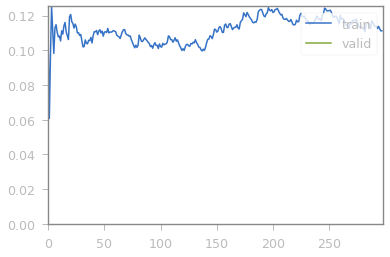

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 70 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5899


epoch,train_loss,valid_loss,accuracy,time
0,0.110029,0.045719,0.903308,01:37


Better model found at epoch 0 with accuracy value: 0.9033079147338867.


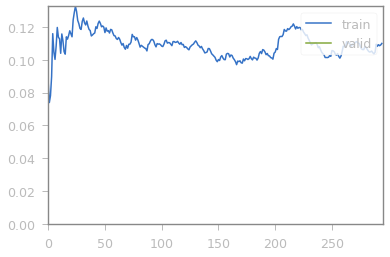

************Round:  9
TTA Accuracy:0.8088808655738831
cycle 0 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 70 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5829


epoch,train_loss,valid_loss,accuracy,time
0,0.117661,0.035057,0.908154,01:38


Better model found at epoch 0 with accuracy value: 0.9081544876098633.


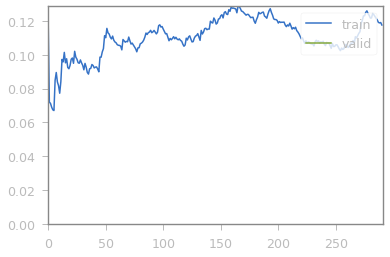

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 65
Min frequency is 52
Min probability = 0.7200000000000001
Dropped 75 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5754


epoch,train_loss,valid_loss,accuracy,time
0,0.109074,0.040169,0.907826,01:37


Better model found at epoch 0 with accuracy value: 0.9078260660171509.


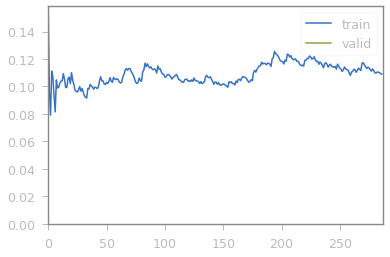

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 74 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5680


epoch,train_loss,valid_loss,accuracy,time
0,0.126373,0.047268,0.911092,01:33


Better model found at epoch 0 with accuracy value: 0.9110915660858154.


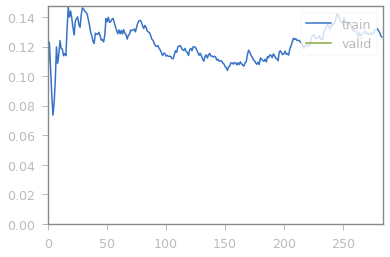

************Round:  12
TTA Accuracy:0.805880606174469
cycle 0 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 77 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5603


epoch,train_loss,valid_loss,accuracy,time
0,0.142214,0.041299,0.911607,01:32


Better model found at epoch 0 with accuracy value: 0.9116071462631226.


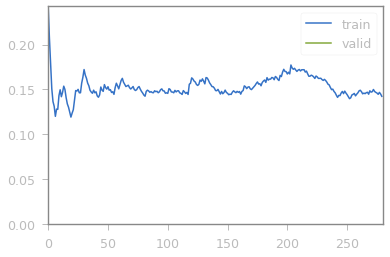

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 64
Min frequency is 48
Min probability = 0.675
Dropped 66 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5537


epoch,train_loss,valid_loss,accuracy,time
0,0.888538,0.930727,0.899729,01:31


Better model found at epoch 0 with accuracy value: 0.8997290134429932.


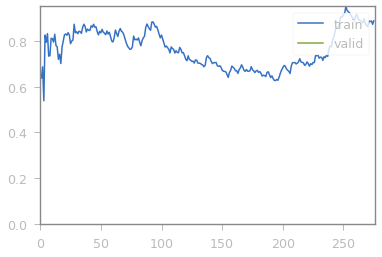

delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 85 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6582


epoch,train_loss,valid_loss,accuracy,time
0,0.151889,0.048981,0.930091,01:47


Better model found at epoch 0 with accuracy value: 0.9300912022590637.


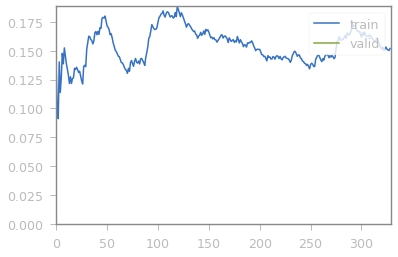

************Round:  0
TTA Accuracy:0.8046804666519165
cycle 1 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 91 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6491


epoch,train_loss,valid_loss,accuracy,time
0,0.122967,0.040787,0.907550,01:46


Better model found at epoch 0 with accuracy value: 0.9075500965118408.


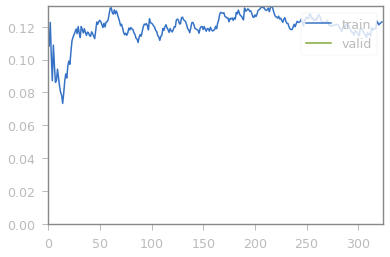

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 75 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6416


epoch,train_loss,valid_loss,accuracy,time
0,0.099340,0.026153,0.919719,01:45


Better model found at epoch 0 with accuracy value: 0.919719398021698.


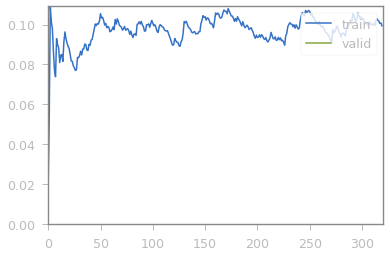

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 76 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6340


epoch,train_loss,valid_loss,accuracy,time
0,0.099980,0.025181,0.923502,01:45


Better model found at epoch 0 with accuracy value: 0.9235015511512756.


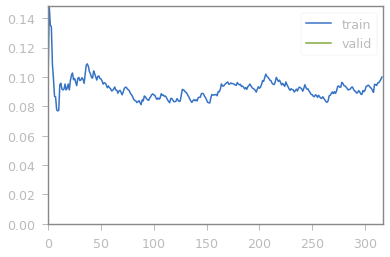

************Round:  3
TTA Accuracy:0.8076807856559753
cycle 1 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 82 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6258


epoch,train_loss,valid_loss,accuracy,time
0,0.085608,0.023565,0.919265,01:42


Better model found at epoch 0 with accuracy value: 0.9192646145820618.


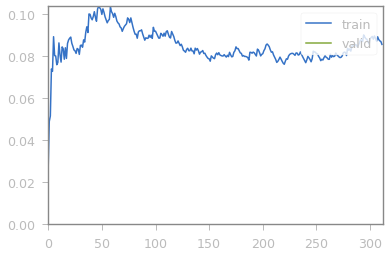

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 57
Min probability = 0.7772727272727273
Dropped 78 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6180


epoch,train_loss,valid_loss,accuracy,time
0,0.078415,0.018385,0.915049,01:41


Better model found at epoch 0 with accuracy value: 0.9150485396385193.


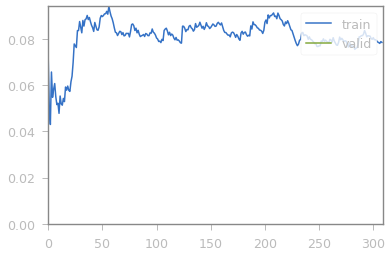

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 82 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6098


epoch,train_loss,valid_loss,accuracy,time
0,0.091682,0.021338,0.909762,01:40


Better model found at epoch 0 with accuracy value: 0.9097620844841003.


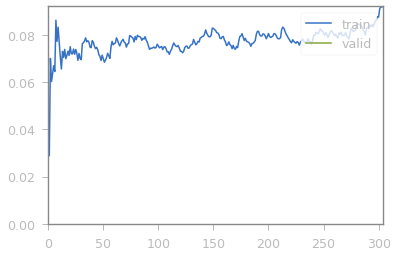

************Round:  6
TTA Accuracy:0.8115811347961426
cycle 1 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 69 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6029


epoch,train_loss,valid_loss,accuracy,time
0,0.063659,0.022248,0.899585,01:39


Better model found at epoch 0 with accuracy value: 0.8995850682258606.


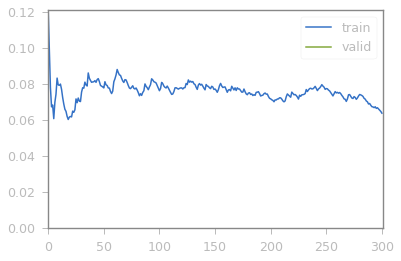

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 67 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5962


epoch,train_loss,valid_loss,accuracy,time
0,0.084073,0.019406,0.895134,01:38


Better model found at epoch 0 with accuracy value: 0.8951342105865479.


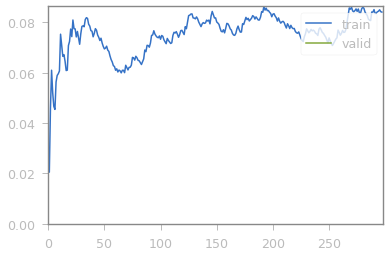

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 52
Min probability = 0.7200000000000001
Dropped 73 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5889


epoch,train_loss,valid_loss,accuracy,time
0,0.068639,0.018207,0.899745,01:37


Better model found at epoch 0 with accuracy value: 0.8997451066970825.


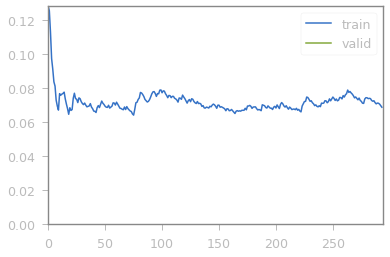

************Round:  9
TTA Accuracy:0.8046804666519165
cycle 1 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742), 24: (11.669416529173537, 19.53195333480835)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 64
Min frequency is 52
Min probability = 0.7312500000000001
Dropped 69 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5820


epoch,train_loss,valid_loss,accuracy,time
0,0.073846,0.018770,0.922680,01:38


Better model found at epoch 0 with accuracy value: 0.9226804375648499.


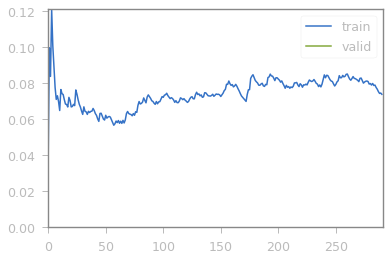

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 69 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5751


epoch,train_loss,valid_loss,accuracy,time
0,0.069991,0.022573,0.915652,01:35


Better model found at epoch 0 with accuracy value: 0.9156521558761597.


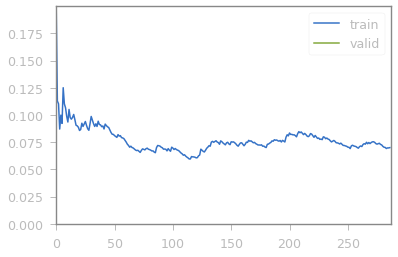

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 76 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5675


epoch,train_loss,valid_loss,accuracy,time
0,0.076870,0.017642,0.911013,01:33


Better model found at epoch 0 with accuracy value: 0.9110132455825806.


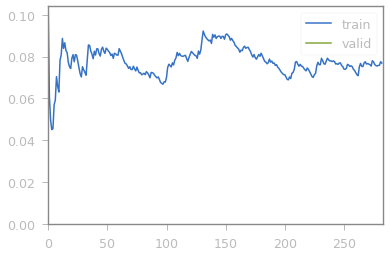

************Round:  12
TTA Accuracy:0.8088808655738831
cycle 1 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742), 24: (11.669416529173537, 19.53195333480835), 27: (14.879256037198141, 19.111913442611694)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 49
Min probability = 0.6890625
Dropped 65 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5610


epoch,train_loss,valid_loss,accuracy,time
0,0.103823,0.032278,0.915330,01:32


Better model found at epoch 0 with accuracy value: 0.9153297543525696.


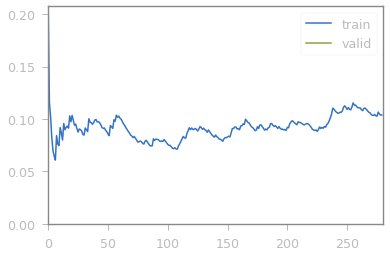

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 49
Min probability = 0.7000000000000001
Dropped 75 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5535


epoch,train_loss,valid_loss,accuracy,time
0,0.739093,0.718267,0.916893,01:31


Better model found at epoch 0 with accuracy value: 0.9168925285339355.


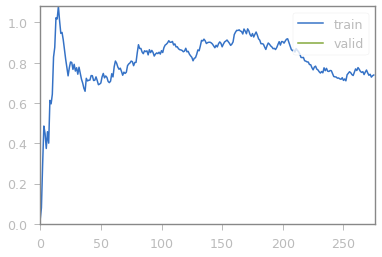

delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 92 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6575


epoch,train_loss,valid_loss,accuracy,time
0,0.112517,0.031287,0.923194,01:47


Better model found at epoch 0 with accuracy value: 0.9231939315795898.


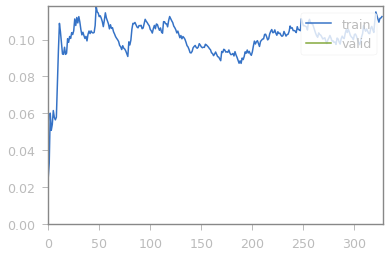

************Round:  0
TTA Accuracy:0.8031803369522095
cycle 2 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742), 24: (11.669416529173537, 19.53195333480835), 27: (14.879256037198141, 19.111913442611694), 30: (1.3799310034498302, 19.681966304779053)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 86 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6489


epoch,train_loss,valid_loss,accuracy,time
0,0.078423,0.025020,0.916731,01:46


Better model found at epoch 0 with accuracy value: 0.9167309403419495.


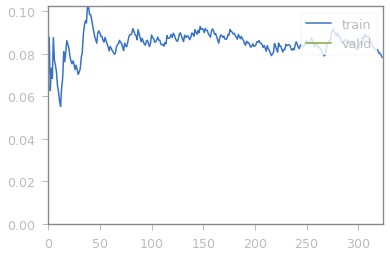

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 74 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6415


epoch,train_loss,valid_loss,accuracy,time
0,0.075022,0.014259,0.907249,01:45


Better model found at epoch 0 with accuracy value: 0.9072486162185669.


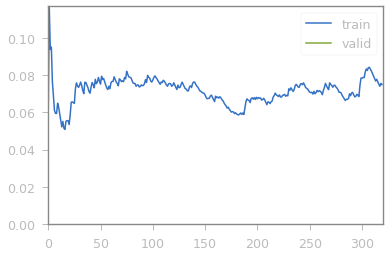

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 85 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6330


epoch,train_loss,valid_loss,accuracy,time
0,0.059254,0.015370,0.908373,01:43


Better model found at epoch 0 with accuracy value: 0.9083728194236755.


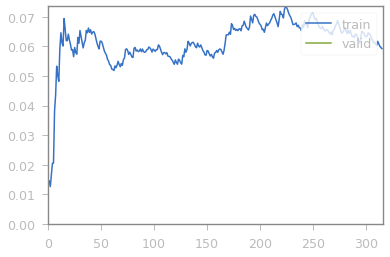

************Round:  3
TTA Accuracy:0.8055805563926697
cycle 2 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742), 24: (11.669416529173537, 19.53195333480835), 27: (14.879256037198141, 19.111913442611694), 30: (1.3799310034498302, 19.681966304779053), 33: (5.054747262636871, 19.441944360733032)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6253


epoch,train_loss,valid_loss,accuracy,time
0,0.064655,0.011436,0.916800,01:43


Better model found at epoch 0 with accuracy value: 0.9168000221252441.


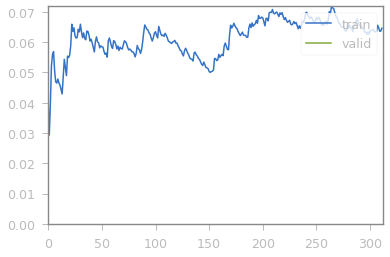

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 78 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6175


epoch,train_loss,valid_loss,accuracy,time
0,0.058299,0.007730,0.919028,01:41


Better model found at epoch 0 with accuracy value: 0.9190283417701721.


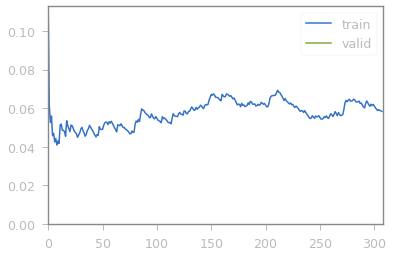

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 80 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6095


epoch,train_loss,valid_loss,accuracy,time
0,0.055015,0.013004,0.908121,01:40


Better model found at epoch 0 with accuracy value: 0.9081214070320129.


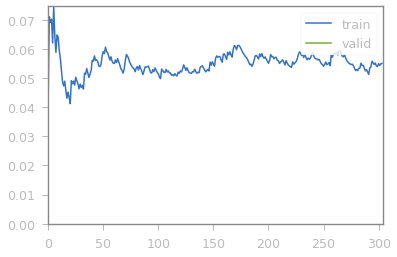

************Round:  6
TTA Accuracy:0.8061805963516235
cycle 2 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742), 24: (11.669416529173537, 19.53195333480835), 27: (14.879256037198141, 19.111913442611694), 30: (1.3799310034498302, 19.681966304779053), 33: (5.054747262636871, 19.441944360733032), 36: (8.579571021448928, 19.381940364837646)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 75 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6020


epoch,train_loss,valid_loss,accuracy,time
0,0.050838,0.010188,0.912791,01:39


Better model found at epoch 0 with accuracy value: 0.9127907156944275.


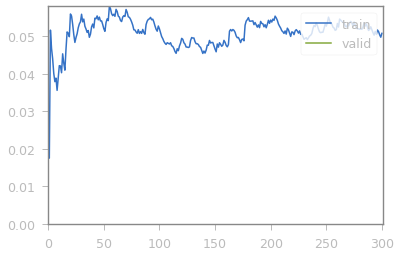

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 67 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5953


epoch,train_loss,valid_loss,accuracy,time
0,0.054312,0.008393,0.903361,01:38


Better model found at epoch 0 with accuracy value: 0.9033613204956055.


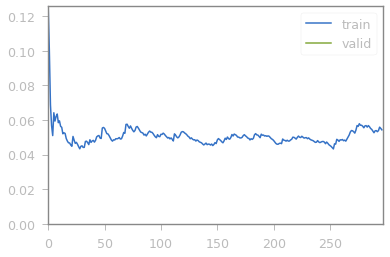

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 70 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5883


epoch,train_loss,valid_loss,accuracy,time
0,0.047614,0.009282,0.915816,01:37


Better model found at epoch 0 with accuracy value: 0.9158163070678711.


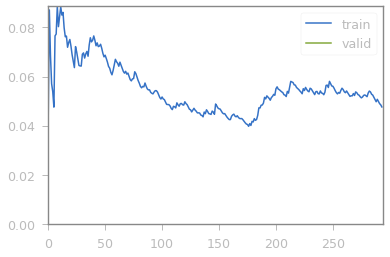

************Round:  9
TTA Accuracy:0.805880606174469
cycle 2 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742), 24: (11.669416529173537, 19.53195333480835), 27: (14.879256037198141, 19.111913442611694), 30: (1.3799310034498302, 19.681966304779053), 33: (5.054747262636871, 19.441944360733032), 36: (8.579571021448928, 19.381940364837646), 39: (11.759412029398531, 19.4119393825531)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 51
Min probability = 0.6954545454545454
Dropped 66 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5817


epoch,train_loss,valid_loss,accuracy,time
0,0.047748,0.013263,0.896819,01:35


Better model found at epoch 0 with accuracy value: 0.8968185782432556.


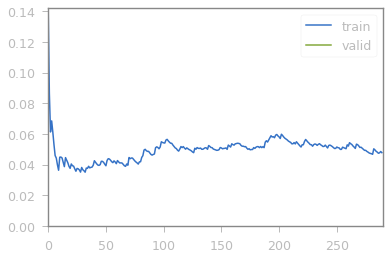

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 65
Min frequency is 51
Min probability = 0.7061538461538461
Dropped 71 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5746


epoch,train_loss,valid_loss,accuracy,time
0,0.054532,0.014423,0.899043,01:34


Better model found at epoch 0 with accuracy value: 0.8990426659584045.


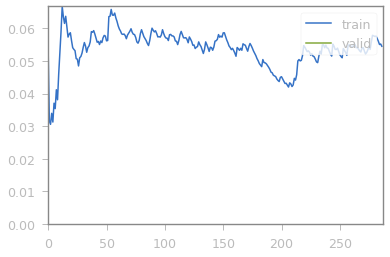

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 65
Min frequency is 49
Min probability = 0.6784615384615384
Dropped 74 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5672


epoch,train_loss,valid_loss,accuracy,time
0,0.057223,0.016370,0.908289,01:33


Better model found at epoch 0 with accuracy value: 0.9082892537117004.


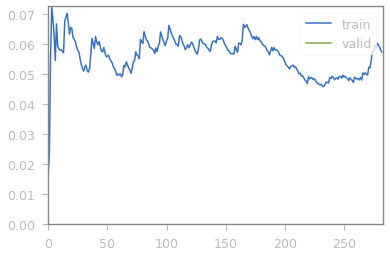

************Round:  12
TTA Accuracy:0.8049805164337158
cycle 2 Error Rate is [{0: (1.364931753412324, 20.102012157440186), 3: (4.964751762411879, 19.77197527885437), 6: (8.354582270886457, 18.841886520385742), 9: (11.519424028798564, 19.111913442611694), 12: (14.804259787010654, 19.4119393825531), 15: (1.274936253187342, 19.53195333480835), 18: (4.904754762261887, 19.231921434402466), 21: (8.534573271336432, 18.841886520385742), 24: (11.669416529173537, 19.53195333480835), 27: (14.879256037198141, 19.111913442611694), 30: (1.3799310034498302, 19.681966304779053), 33: (5.054747262636871, 19.441944360733032), 36: (8.579571021448928, 19.381940364837646), 39: (11.759412029398531, 19.4119393825531), 42: (14.924253787310636, 19.501948356628418)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 48
Min probability = 0.675
Dropped 67 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5605


epoch,train_loss,valid_loss,accuracy,time
0,0.075936,0.017222,0.900089,01:32


Better model found at epoch 0 with accuracy value: 0.9000892043113708.


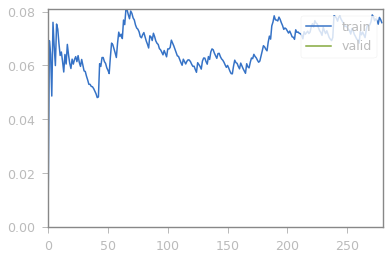

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 64
Min frequency is 47
Min probability = 0.6609375000000001
Dropped 63 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5542


epoch,train_loss,valid_loss,accuracy,time
0,0.744926,0.930377,0.899819,01:31


Better model found at epoch 0 with accuracy value: 0.8998194932937622.


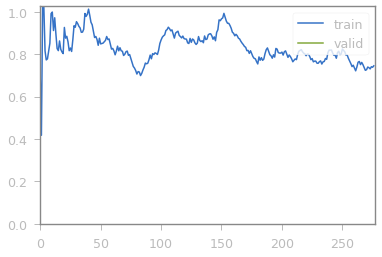

In [35]:
drop_idxx = []
los = []
top_losses = []
n_training_series = 15  # orginally it is 15, but for testing purpose we are using with 1 to check the scheme with custom function.
min_epochs = 1
min_prob=0.5
max_prob=0.9
delta_epochs_per_serie =  0
min_lr = 1e-4
kappa_lr = 1 
k_samples = 0
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
cleaning_cycles = 3 
delta_max = 0.25
accs = []
deltas = []
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        print(f'delta = {delta}')
        loss_func = losses.DampedCELossFlat(num_classes=196,delta=delta,reduction ='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            acc.append(tta_acc)
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH="models/ce_aircrafts_dumpsCls_sym20_b4_"+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv("ce_aircrafts_dumpsCls_sym20_b4_"+str(c)+"_"+str(n)+".csv", index = False)     
    

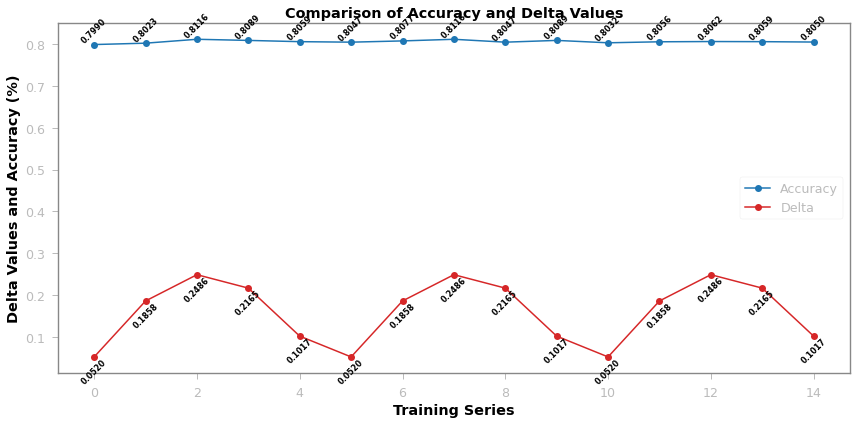

In [37]:

plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 87 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6580


epoch,train_loss,valid_loss,accuracy,time
0,0.060538,0.018416,0.918693,01:48


Better model found at epoch 0 with accuracy value: 0.9186930060386658.


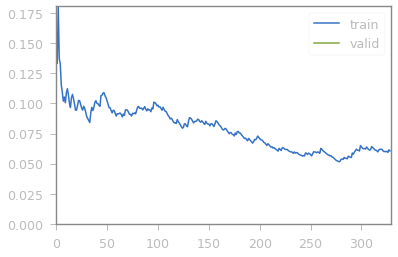

************Round:  0
TTA Accuracy:0.8028802871704102
cycle 0 Error Rate is [{0: (1.3049347532623323, 19.711971282958984)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 80 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6500


epoch,train_loss,valid_loss,accuracy,time
0,0.048768,0.011215,0.915385,01:46


Better model found at epoch 0 with accuracy value: 0.9153845906257629.


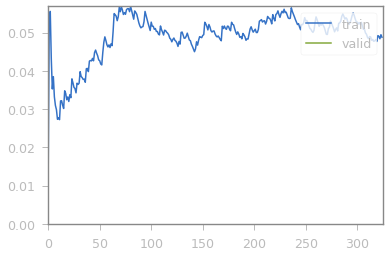

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 84 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6416


epoch,train_loss,valid_loss,accuracy,time
0,0.041112,0.009091,0.910366,01:45


Better model found at epoch 0 with accuracy value: 0.9103663563728333.


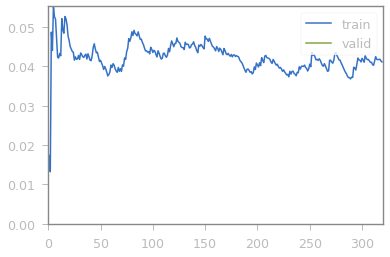

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 77 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6339


epoch,train_loss,valid_loss,accuracy,time
0,0.038905,0.006362,0.918706,01:44


Better model found at epoch 0 with accuracy value: 0.9187055826187134.


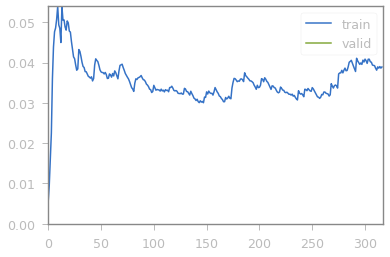

************Round:  3
TTA Accuracy:0.8094809651374817
cycle 0 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 66
Min frequency is 58
Min probability = 0.7909090909090909
Dropped 76 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6263


epoch,train_loss,valid_loss,accuracy,time
0,0.036429,0.004915,0.919329,01:43


Better model found at epoch 0 with accuracy value: 0.919329047203064.


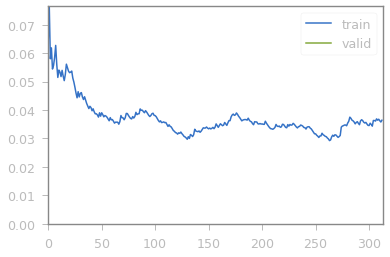

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 57
Min probability = 0.7772727272727273
Dropped 80 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6183


epoch,train_loss,valid_loss,accuracy,time
0,0.036028,0.003338,0.906149,01:41


Better model found at epoch 0 with accuracy value: 0.9061488509178162.


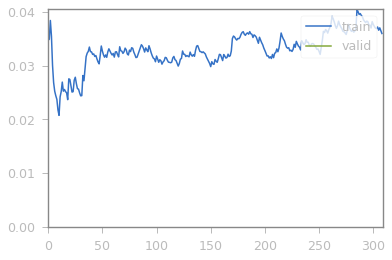

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 75 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6108


epoch,train_loss,valid_loss,accuracy,time
0,0.024762,0.006901,0.917281,01:40


Better model found at epoch 0 with accuracy value: 0.917280912399292.


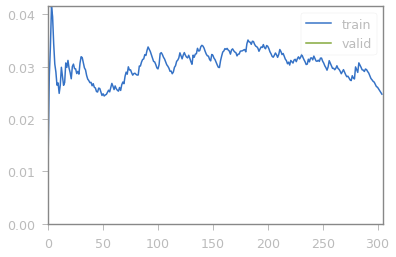

************Round:  6
TTA Accuracy:0.8085808753967285
cycle 0 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 65
Min frequency is 55
Min probability = 0.7615384615384615
Dropped 78 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6030


epoch,train_loss,valid_loss,accuracy,time
0,0.031276,0.004126,0.909619,01:39


Better model found at epoch 0 with accuracy value: 0.9096185564994812.


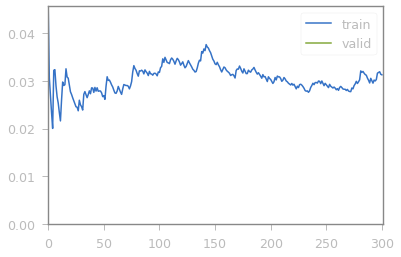

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 65
Min frequency is 54
Min probability = 0.7476923076923078
Dropped 72 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5958


epoch,train_loss,valid_loss,accuracy,time
0,0.029985,0.004924,0.899244,01:39


Better model found at epoch 0 with accuracy value: 0.8992443084716797.


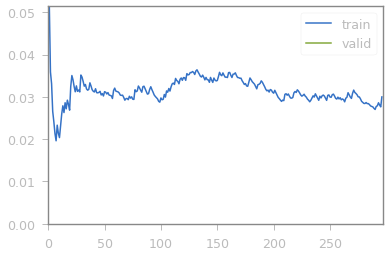

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 64
Min frequency is 53
Min probability = 0.7453125
Dropped 83 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5875


epoch,train_loss,valid_loss,accuracy,time
0,0.035131,0.004443,0.907234,01:37


Better model found at epoch 0 with accuracy value: 0.9072340130805969.


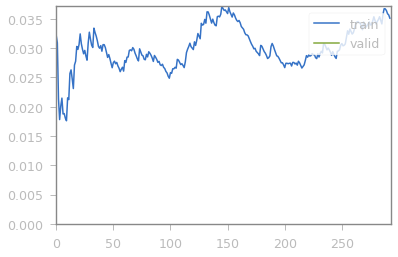

************Round:  9
TTA Accuracy:0.8046804666519165
cycle 0 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 63
Min frequency is 48
Min probability = 0.6857142857142857
Dropped 72 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5803


epoch,train_loss,valid_loss,accuracy,time
0,0.031390,0.006742,0.905172,01:35


Better model found at epoch 0 with accuracy value: 0.9051724076271057.


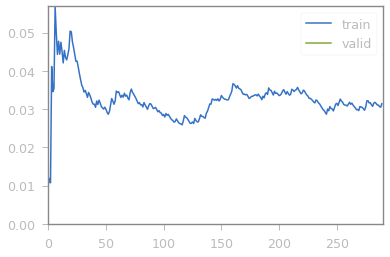

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 63
Min frequency is 48
Min probability = 0.6857142857142857
Dropped 70 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5733


epoch,train_loss,valid_loss,accuracy,time
0,0.031797,0.009221,0.904014,01:34


Better model found at epoch 0 with accuracy value: 0.904013991355896.


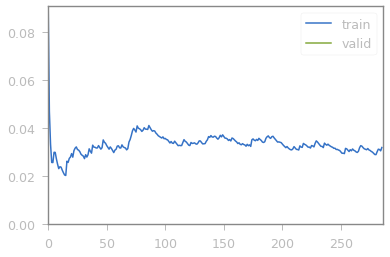

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 63
Min frequency is 48
Min probability = 0.6857142857142857
Dropped 80 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5653


epoch,train_loss,valid_loss,accuracy,time
0,0.031274,0.005467,0.920354,01:33


Better model found at epoch 0 with accuracy value: 0.9203540086746216.


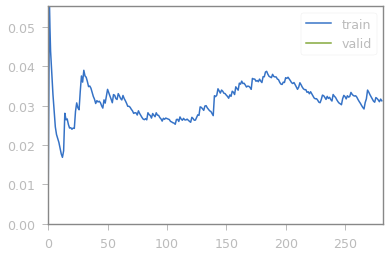

************Round:  12
TTA Accuracy:0.8031803369522095
cycle 0 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 62
Min frequency is 47
Min probability = 0.682258064516129
Dropped 72 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5581


epoch,train_loss,valid_loss,accuracy,time
0,0.050966,0.008756,0.910394,01:32


Better model found at epoch 0 with accuracy value: 0.9103942513465881.


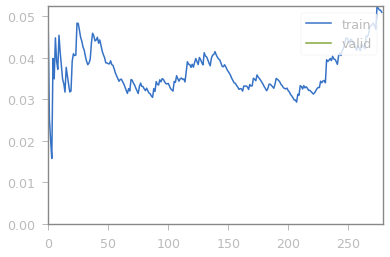

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 62
Min frequency is 47
Min probability = 0.682258064516129
Dropped 67 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5514


epoch,train_loss,valid_loss,accuracy,time
0,0.684998,0.746512,0.913793,01:31


Better model found at epoch 0 with accuracy value: 0.9137930870056152.


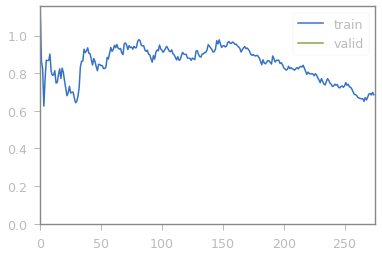

delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,0.050600,0.015631,0.910266,01:48


Better model found at epoch 0 with accuracy value: 0.9102661609649658.


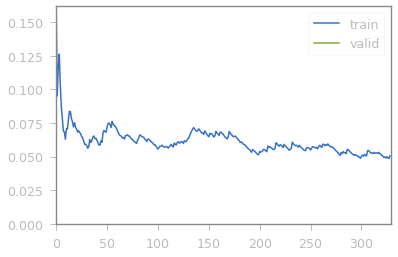

************Round:  0
TTA Accuracy:0.8001800179481506
cycle 1 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 84 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6495


epoch,train_loss,valid_loss,accuracy,time
0,0.039983,0.005237,0.916089,01:47


Better model found at epoch 0 with accuracy value: 0.9160892963409424.


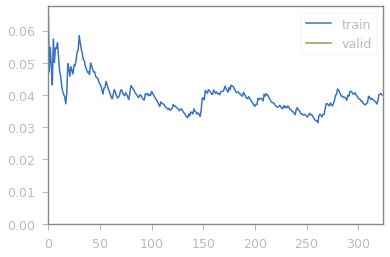

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 79 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6416


epoch,train_loss,valid_loss,accuracy,time
0,0.030489,0.007520,0.913484,01:45


Better model found at epoch 0 with accuracy value: 0.9134840369224548.


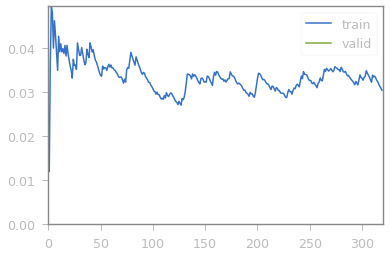

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 82 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6334


epoch,train_loss,valid_loss,accuracy,time
0,0.029435,0.003620,0.917852,01:44


Better model found at epoch 0 with accuracy value: 0.9178515076637268.


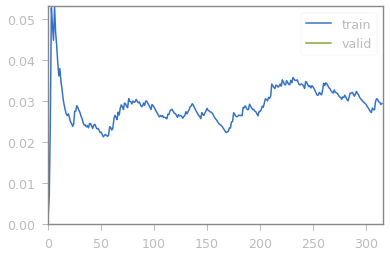

************Round:  3
TTA Accuracy:0.8091809153556824
cycle 1 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6257


epoch,train_loss,valid_loss,accuracy,time
0,0.029823,0.004144,0.906475,01:42


Better model found at epoch 0 with accuracy value: 0.9064748287200928.


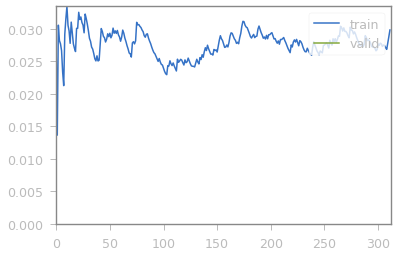

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 74 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6183


epoch,train_loss,valid_loss,accuracy,time
0,0.024304,0.003908,0.908576,01:42


Better model found at epoch 0 with accuracy value: 0.9085760712623596.


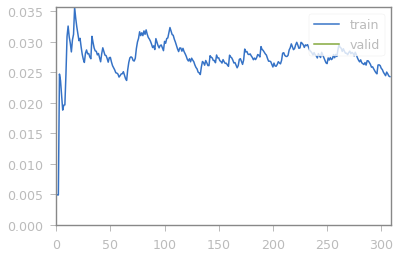

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 78 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6105


epoch,train_loss,valid_loss,accuracy,time
0,0.027455,0.002846,0.915643,01:40


Better model found at epoch 0 with accuracy value: 0.9156429171562195.


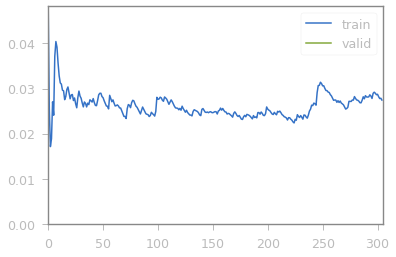

************Round:  6
TTA Accuracy:0.8085808753967285
cycle 1 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 74 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6031


epoch,train_loss,valid_loss,accuracy,time
0,0.024366,0.004906,0.894693,01:39


Better model found at epoch 0 with accuracy value: 0.8946931958198547.


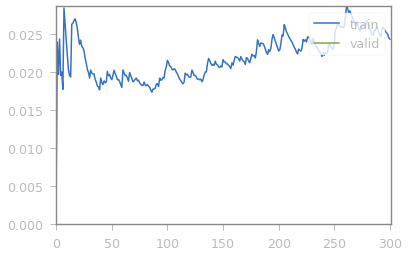

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 71 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5960


epoch,train_loss,valid_loss,accuracy,time
0,0.023032,0.001787,0.899329,01:38


Better model found at epoch 0 with accuracy value: 0.899328887462616.


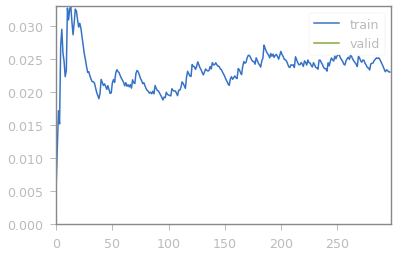

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 75 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5885


epoch,train_loss,valid_loss,accuracy,time
0,0.028154,0.004082,0.903144,01:36


Better model found at epoch 0 with accuracy value: 0.903143584728241.


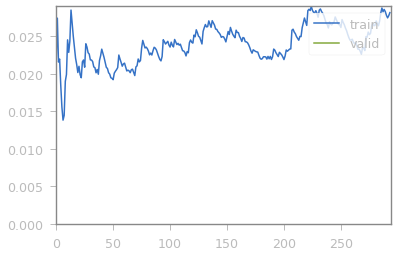

************Round:  9
TTA Accuracy:0.8097809553146362
cycle 1 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715), 24: (11.72941352932353, 19.021904468536377)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 64
Min frequency is 51
Min probability = 0.7171875
Dropped 68 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5817


epoch,train_loss,valid_loss,accuracy,time
0,0.029354,0.006653,0.897678,01:35


Better model found at epoch 0 with accuracy value: 0.8976784348487854.


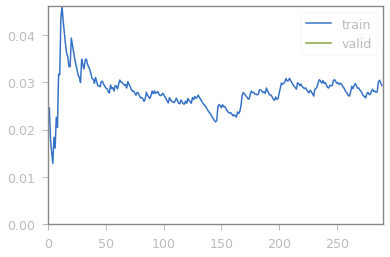

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 73 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5744


epoch,train_loss,valid_loss,accuracy,time
0,0.025711,0.005399,0.907665,01:34


Better model found at epoch 0 with accuracy value: 0.907665491104126.


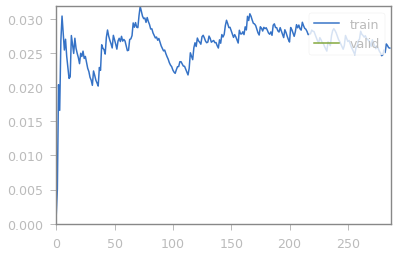

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 73 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5671


epoch,train_loss,valid_loss,accuracy,time
0,0.030889,0.004069,0.917108,01:33


Better model found at epoch 0 with accuracy value: 0.9171075820922852.


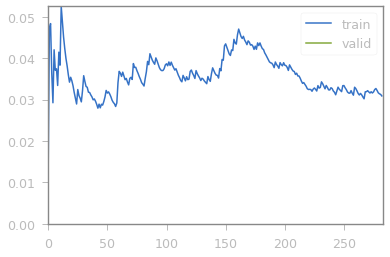

************Round:  12
TTA Accuracy:0.8067806959152222
cycle 1 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715), 24: (11.72941352932353, 19.021904468536377), 27: (14.939253037348132, 19.321930408477783)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 49
Min probability = 0.6890625
Dropped 68 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5603


epoch,train_loss,valid_loss,accuracy,time
0,0.039815,0.002878,0.907143,01:32


Better model found at epoch 0 with accuracy value: 0.9071428775787354.


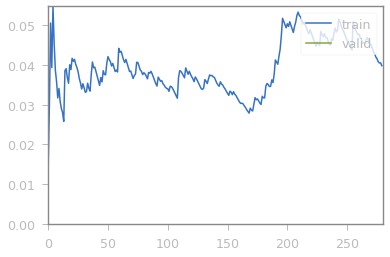

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 64
Min frequency is 49
Min probability = 0.6890625
Dropped 74 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5529


epoch,train_loss,valid_loss,accuracy,time
0,0.867697,0.877964,0.906787,01:31


Better model found at epoch 0 with accuracy value: 0.9067873358726501.


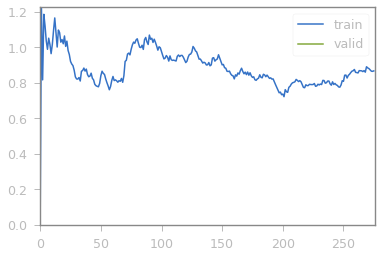

delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 86 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6581


epoch,train_loss,valid_loss,accuracy,time
0,0.046693,0.015305,0.899696,01:48


Better model found at epoch 0 with accuracy value: 0.8996960520744324.


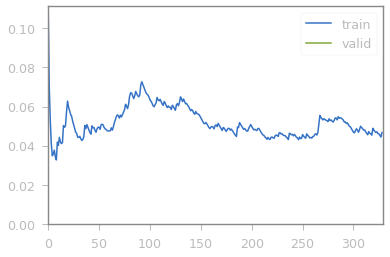

************Round:  0
TTA Accuracy:0.8013801574707031
cycle 2 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715), 24: (11.72941352932353, 19.021904468536377), 27: (14.939253037348132, 19.321930408477783), 30: (1.2899355032248372, 19.861984252929688)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 82 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6499


epoch,train_loss,valid_loss,accuracy,time
0,0.028070,0.009283,0.910701,01:46


Better model found at epoch 0 with accuracy value: 0.9107005596160889.


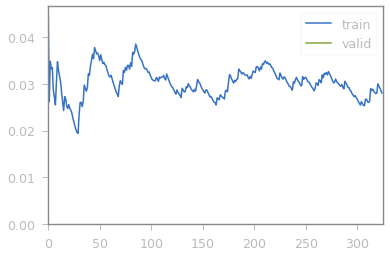

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 83 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6416


epoch,train_loss,valid_loss,accuracy,time
0,0.024310,0.002714,0.908807,01:45


Better model found at epoch 0 with accuracy value: 0.9088074564933777.


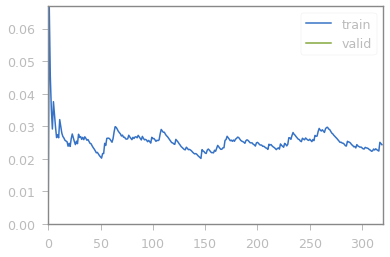

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 81 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6335


epoch,train_loss,valid_loss,accuracy,time
0,0.024659,0.004447,0.921863,01:44


Better model found at epoch 0 with accuracy value: 0.9218626618385315.


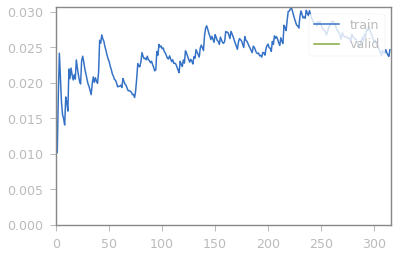

************Round:  3
TTA Accuracy:0.8013801574707031
cycle 2 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715), 24: (11.72941352932353, 19.021904468536377), 27: (14.939253037348132, 19.321930408477783), 30: (1.2899355032248372, 19.861984252929688), 33: (4.979751012449373, 19.861984252929688)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 66
Min frequency is 59
Min probability = 0.8045454545454546
Dropped 84 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6251


epoch,train_loss,valid_loss,accuracy,time
0,0.024260,0.002673,0.908800,01:43


Better model found at epoch 0 with accuracy value: 0.9088000059127808.


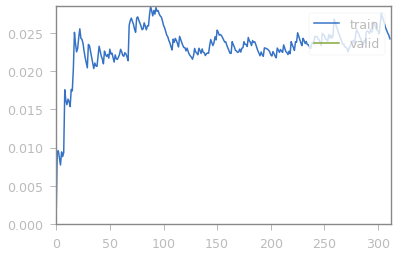

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 58
Min probability = 0.7909090909090909
Dropped 73 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6178


epoch,train_loss,valid_loss,accuracy,time
0,0.023291,0.002180,0.916599,01:41


Better model found at epoch 0 with accuracy value: 0.9165992140769958.


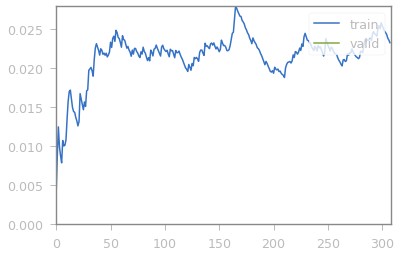

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 57
Min probability = 0.7772727272727273
Dropped 78 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6100


epoch,train_loss,valid_loss,accuracy,time
0,0.022128,0.001509,0.928689,01:40


Better model found at epoch 0 with accuracy value: 0.9286885261535645.


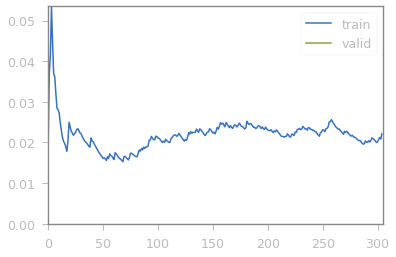

************Round:  6
TTA Accuracy:0.8079807758331299
cycle 2 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715), 24: (11.72941352932353, 19.021904468536377), 27: (14.939253037348132, 19.321930408477783), 30: (1.2899355032248372, 19.861984252929688), 33: (4.979751012449373, 19.861984252929688), 36: (8.504574771261442, 19.20192241668701)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 76 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6024


epoch,train_loss,valid_loss,accuracy,time
0,0.023287,0.004769,0.918605,01:39


Better model found at epoch 0 with accuracy value: 0.9186046719551086.


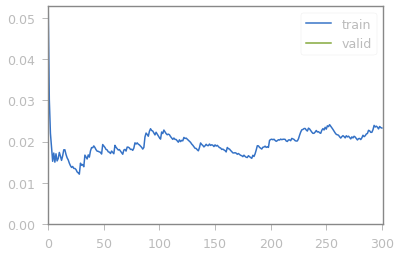

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 64
Min frequency is 54
Min probability = 0.759375
Dropped 77 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5947


epoch,train_loss,valid_loss,accuracy,time
0,0.021327,0.001971,0.905803,01:37


Better model found at epoch 0 with accuracy value: 0.9058032035827637.


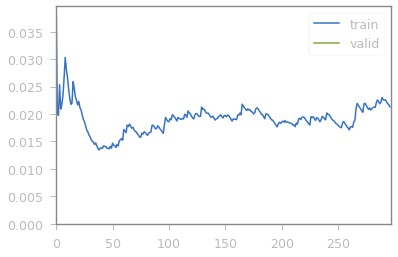

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 64
Min frequency is 53
Min probability = 0.7453125
Dropped 78 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5869


epoch,train_loss,valid_loss,accuracy,time
0,0.018326,0.004787,0.908781,01:36


Better model found at epoch 0 with accuracy value: 0.9087809324264526.


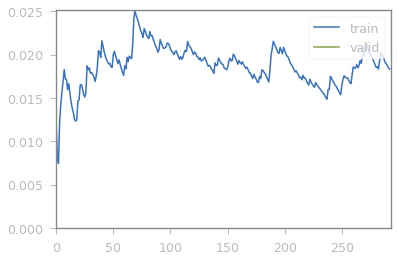

************Round:  9
TTA Accuracy:0.8040804266929626
cycle 2 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715), 24: (11.72941352932353, 19.021904468536377), 27: (14.939253037348132, 19.321930408477783), 30: (1.2899355032248372, 19.861984252929688), 33: (4.979751012449373, 19.861984252929688), 36: (8.504574771261442, 19.20192241668701), 39: (11.969401529923507, 19.591957330703735)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 64
Min frequency is 53
Min probability = 0.7453125
Dropped 74 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5795


epoch,train_loss,valid_loss,accuracy,time
0,0.022041,0.001875,0.896462,01:35


Better model found at epoch 0 with accuracy value: 0.8964624404907227.


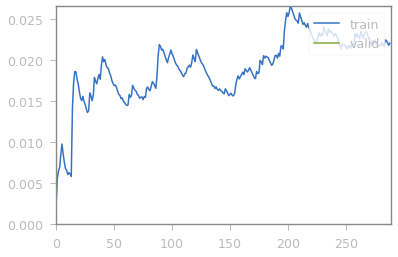

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 64
Min frequency is 52
Min probability = 0.7312500000000001
Dropped 64 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5731


epoch,train_loss,valid_loss,accuracy,time
0,0.024596,0.003088,0.910995,01:34


Better model found at epoch 0 with accuracy value: 0.9109947681427002.


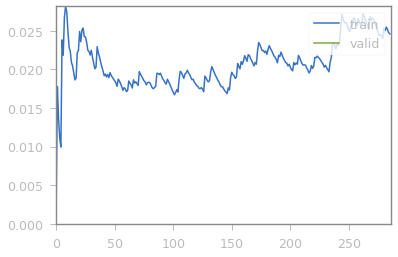

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 51
Min probability = 0.7171875
Dropped 73 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5658


epoch,train_loss,valid_loss,accuracy,time
0,0.026124,0.003432,0.910698,01:33


Better model found at epoch 0 with accuracy value: 0.9106984734535217.


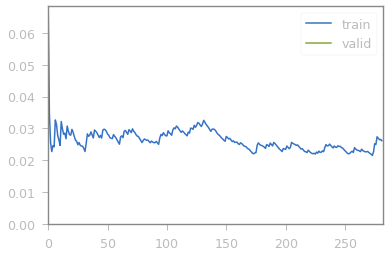

************Round:  12
TTA Accuracy:0.8043804168701172
cycle 2 Error Rate is [{0: (1.3049347532623323, 19.711971282958984), 3: (4.919754012299382, 19.05190348625183), 6: (8.384580770961447, 19.14191246032715), 9: (11.879406029698513, 19.53195333480835), 12: (15.2092395380231, 19.681966304779053), 15: (1.3199340032998386, 19.981998205184937), 18: (4.99475026248688, 19.081908464431763), 21: (8.429578521073944, 19.14191246032715), 24: (11.72941352932353, 19.021904468536377), 27: (14.939253037348132, 19.321930408477783), 30: (1.2899355032248372, 19.861984252929688), 33: (4.979751012449373, 19.861984252929688), 36: (8.504574771261442, 19.20192241668701), 39: (11.969401529923507, 19.591957330703735), 42: (15.134243287835613, 19.56195831298828)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 63
Min frequency is 49
Min probability = 0.7000000000000001
Dropped 65 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5593


epoch,train_loss,valid_loss,accuracy,time
0,0.029482,0.006997,0.893560,01:32


Better model found at epoch 0 with accuracy value: 0.8935599327087402.


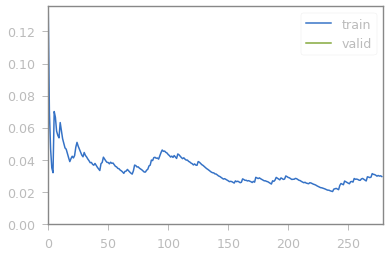

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 61
Min frequency is 49
Min probability = 0.7229508196721312
Dropped 74 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5519


epoch,train_loss,valid_loss,accuracy,time
0,0.855327,0.793030,0.907525,01:31


Better model found at epoch 0 with accuracy value: 0.9075249433517456.


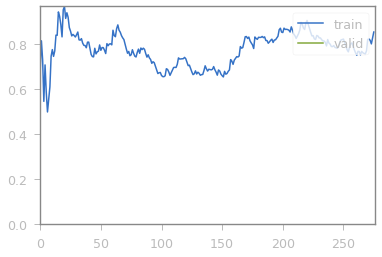

In [40]:
delta_max = 0.50
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        print(f'delta = {delta}')
        loss_func = losses.DampedCELossFlat(num_classes=196,delta=delta,reduction ='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH="models/ce_Clsdump40_sym20_b4_"+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv("ce_Clsdump40_sym20_b4_"+str(c)+"_"+str(n)+".csv", index = False)     
    

In [41]:
for i in range(len(accs)):
    print(f'acc:{accs[i]}, delta:{deltas[i]}')

acc:0.8028802871704102, delta:0.10395584540887966
acc:0.8094809651374817, delta:0.37157241273869707
acc:0.8085808753967285, delta:0.49726094768413664
acc:0.8046804666519165, delta:0.43301270189221935
acc:0.8031803369522095, delta:0.20336832153790002
acc:0.8001800179481506, delta:0.10395584540887966
acc:0.8091809153556824, delta:0.37157241273869707
acc:0.8085808753967285, delta:0.49726094768413664
acc:0.8097809553146362, delta:0.43301270189221935
acc:0.8067806959152222, delta:0.20336832153790002
acc:0.8013801574707031, delta:0.10395584540887966
acc:0.8013801574707031, delta:0.37157241273869707
acc:0.8079807758331299, delta:0.49726094768413664
acc:0.8040804266929626, delta:0.43301270189221935
acc:0.8043804168701172, delta:0.20336832153790002


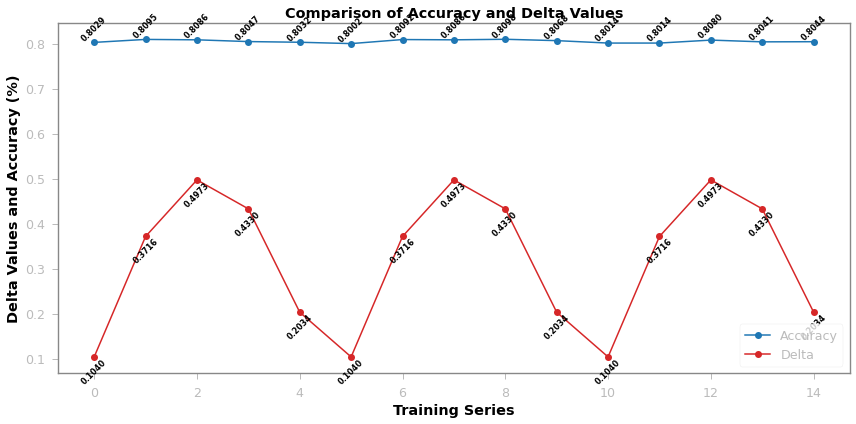

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
